# **Machine Learning and GenAI in Geopolitical Conflict Analysis And Mitigation**

## **Part 2 - RandomForest and LLM model integration**

In [ ]:
!pip install statsmodels
!pip install --upgrade pip
!pip install imbalanced-learn
!pip install --upgrade openai==0.28

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#/content/drive/MyDrive/ACLED

In [ ]:
# Define the folder path
folder_path = '/content/drive/MyDrive/ACLED'

# List all files in the folder
print("Files in the ACLED folder:")
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    print(file_name)

Files in the ACLED folder:
Africa_1997-2024_Oct04.csv
MiddleEast_2015-2024_Oct04.csv
LatinAmerica_2018-2024_Oct04.csv
Asia-Pacific_2018-2024_Oct04.csv
Europe-Central-Asia_2018-2024_Oct04.csv
USA_Canada_2020_2024_Oct04.csv


# **Accessing Data and importing librares and dependencies**

In [ ]:
#importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Input data files are available in the read-only "../input/" directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        """

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        "

In [ ]:
# Define the paths to the CSV files - working in kaggle notebook
"""
file_paths = [
    "/kaggle/input/acled-conflict-data/USA_Canada_2020_2024_Jun28.csv",
    "/kaggle/input/acled-conflict-data/Africa_1997-2024_Jun28.csv",
    "/kaggle/input/acled-conflict-data/LatinAmerica_2018-2024_Jun28.csv",
    "/kaggle/input/acled-conflict-data/MiddleEast_2015-2024_Jun28.csv",
    "/kaggle/input/acled-conflict-data/Asia-Pacific_2018-2024_Jun28.csv",
    "/kaggle/input/acled-conflict-data/Europe-Central-Asia_2018-2024_Jun28.csv"
]
"""

'\nfile_paths = [\n    "/kaggle/input/acled-conflict-data/USA_Canada_2020_2024_Jun28.csv",\n    "/kaggle/input/acled-conflict-data/Africa_1997-2024_Jun28.csv",\n    "/kaggle/input/acled-conflict-data/LatinAmerica_2018-2024_Jun28.csv",\n    "/kaggle/input/acled-conflict-data/MiddleEast_2015-2024_Jun28.csv",\n    "/kaggle/input/acled-conflict-data/Asia-Pacific_2018-2024_Jun28.csv",\n    "/kaggle/input/acled-conflict-data/Europe-Central-Asia_2018-2024_Jun28.csv"\n]\n'

In [ ]:
# List of CSV files from our ACLED folder dir
csv_files = ['Africa_1997-2024_Oct04.csv', 'LatinAmerica_2018-2024_Oct04.csv',
             'Asia-Pacific_2018-2024_Oct04.csv', 'MiddleEast_2015-2024_Oct04.csv',
             'Europe-Central-Asia_2018-2024_Oct04.csv', 'USA_Canada_2020_2024_Oct04.csv']

# Construct the full file paths
csv_files_with_path = [os.path.join(folder_path, file_name) for file_name in csv_files]

# Load the files into DataFrames, matching file names with DataFrame names
Africa_df = pd.read_csv(csv_files_with_path[0])
LatinAmerica_df = pd.read_csv(csv_files_with_path[1])
Asia_df = pd.read_csv(csv_files_with_path[2])
MiddleEast_df = pd.read_csv(csv_files_with_path[3])
Europe_df = pd.read_csv(csv_files_with_path[4])
USA_Canada_df = pd.read_csv(csv_files_with_path[5])

print("Our 6 datasets are ready to read now.")

Our 6 datasets are ready to read now.


# **Data Aggregation And Preprocessing.**

We undertake various tasks to combine and clean our conflict dataset making it ready for analysis and model implementation.

In [ ]:
# Combine datasets
combined_df = pd.concat([Africa_df, Asia_df, Europe_df, LatinAmerica_df, MiddleEast_df, USA_Canada_df], ignore_index=True)

In [ ]:
# Save the combined DataFrame to a CSV file - optional
#combined_df.to_csv('combined_df.csv', index=False)

In [ ]:
# copy of our combined df
combined_df_copy = combined_df.copy()

In [ ]:
# To keep track of which data comes from which region, we considered adding a new column indicating the region for each row.
Africa_df['Region'] = 'Africa'
Asia_df['Region'] = 'Asia'
Europe_df['Region'] = 'Europe'
LatinAmerica_df['Region'] = 'Latin America'
MiddleEast_df['Region'] = 'Middle East'
USA_Canada_df['Region'] = 'USA/Canada'

combined_df = pd.concat([Africa_df, Asia_df, Europe_df, LatinAmerica_df, MiddleEast_df, USA_Canada_df], ignore_index=True)

In [ ]:
# Check the combined dataframe
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282666 entries, 0 to 2282665
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   event_id_cnty       object 
 1   event_date          object 
 2   year                int64  
 3   time_precision      int64  
 4   disorder_type       object 
 5   event_type          object 
 6   sub_event_type      object 
 7   actor1              object 
 8   assoc_actor_1       object 
 9   inter1              object 
 10  actor2              object 
 11  assoc_actor_2       object 
 12  inter2              object 
 13  interaction         object 
 14  civilian_targeting  object 
 15  iso                 int64  
 16  region              object 
 17  country             object 
 18  admin1              object 
 19  admin2              object 
 20  admin3              object 
 21  location            object 
 22  latitude            float64
 23  longitude           float64
 24  geo_precision       int6

In [ ]:
# Previewing the first 5 observations of our merged datasets.
combined_df.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,Region
0,BFO12659,2024-10-04,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Burkina Faso (2022-),NaN,State forces,...,10.0116,-4.0287,2,Undisclosed Source,Local partner-Other,"On 4 October 2024, the Burkinabe force carried...",5,NaN,1728335020,Africa
1,BFO12661,2024-10-04,2024,1,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,14.0875,-1.6418,2,Al Zallaqa; Whatsapp,New media,"On 4 October 2024, JNIM militants carried out ...",0,NaN,1728335020,Africa
2,BFO12665,2024-10-04,2024,1,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,13.6758,-2.3336,1,Whatsapp,New media,"On 4 October 2024, JNIM militants attacked a p...",0,NaN,1728335020,Africa
3,BFO12682,2024-10-04,2024,1,Strategic developments,Strategic developments,Other,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,12.7097,-0.1311,2,Undisclosed Source,Local partner-Other,"Non-violent activity: On 4 October 2024, JNIM ...",0,NaN,1728335020,Africa
4,BFO12687,2024-10-04,2024,1,Demonstrations,Riots,Violent demonstration,Rioters (Burkina Faso),Students (Burkina Faso),Rioters,...,12.4634,-3.4608,1,Facebook,New media,"On 4 October 2024, students from the modern li...",0,crowd size=no report,1728335020,Africa


In [ ]:
# displaying our columns
combined_df.columns


Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp', 'Region'],
      dtype='object')

In [ ]:
# dropping a few columns

drop_columns = ['event_id_cnty', 'assoc_actor_1', 'assoc_actor_2', 'admin3', 'source', 'source_scale', 'notes', 'tags', 'timestamp']


In [ ]:
# Drop the columns
combined_df = combined_df.drop(columns=drop_columns)

In [ ]:
# current size of our columns after dropping
combined_df.columns.size

23

In [ ]:
# Current columns after dropping
combined_df.columns

Index(['event_date', 'year', 'time_precision', 'disorder_type', 'event_type',
       'sub_event_type', 'actor1', 'inter1', 'actor2', 'inter2', 'interaction',
       'civilian_targeting', 'iso', 'region', 'country', 'admin1', 'admin2',
       'location', 'latitude', 'longitude', 'geo_precision', 'fatalities',
       'Region'],
      dtype='object')

In [ ]:
# checking the dtypes of these columns
combined_df.dtypes

,0
event_date,object
year,int64
time_precision,int64
disorder_type,object
event_type,object
sub_event_type,object
actor1,object
inter1,object
actor2,object
inter2,object


In [ ]:
# Convert event_date to datetime and set as index
combined_df['event_date'] = pd.to_datetime(combined_df['event_date'])
combined_df.set_index('event_date', inplace=True)

In [ ]:
# convert year to datetime dtype
combined_df['year'] = pd.to_datetime(combined_df['year'])

In [ ]:
combined_df.index

DatetimeIndex(['2024-10-04', '2024-10-04', '2024-10-04', '2024-10-04',
               '2024-10-04', '2024-10-04', '2024-10-04', '2024-10-04',
               '2024-10-04', '2024-10-04',
               ...
               '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-01',
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='event_date', length=2282666, freq=None)

In [ ]:
# Check for missing values
missing_values = combined_df.isnull().sum()
print(missing_values)

year                        0
time_precision              0
disorder_type               0
event_type                  0
sub_event_type              0
actor1                      0
inter1                      0
actor2                1167358
inter2                1167357
interaction                 0
civilian_targeting    1925089
iso                         0
region                      0
country                     0
admin1                    727
admin2                  65305
location                    0
latitude                    0
longitude                   0
geo_precision               0
fatalities                  0
Region                      0
dtype: int64


In [ ]:
# Handle missing values
'''missing values in numeric columns are replaced with the mean of their respective columns,
and missing values in categorical columns are replaced with the most frequently occurring value.'''

numeric_features = combined_df.select_dtypes(include=[np.number]).columns
categorical_features = combined_df.select_dtypes(include=['object', 'category']).columns

numeric_imputer = SimpleImputer(strategy='mean')
combined_df[numeric_features] = numeric_imputer.fit_transform(combined_df[numeric_features])

categorical_imputer = SimpleImputer(strategy='most_frequent')
combined_df[categorical_features] = categorical_imputer.fit_transform(combined_df[categorical_features])

In [ ]:
# Check for missing values again
missing_values = combined_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 year                  0
time_precision        0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
iso                   0
region                0
country               0
admin1                0
admin2                0
location              0
latitude              0
longitude             0
geo_precision         0
fatalities            0
Region                0
dtype: int64


In [ ]:
# Check for NaN values
nan_values = combined_df.isna().sum()
print("\nNaN Values:\n", nan_values)


NaN Values:
 year                  0
time_precision        0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
iso                   0
region                0
country               0
admin1                0
admin2                0
location              0
latitude              0
longitude             0
geo_precision         0
fatalities            0
Region                0
dtype: int64


In [ ]:
# Check for duplicates
duplicates = combined_df.duplicated().sum()
print("\nDuplicate Rows:", duplicates)



Duplicate Rows: 1246397


In [ ]:
# Drop duplicate rows
combined_df = combined_df.drop_duplicates()

In [ ]:
# Check the number of rows after dropping duplicates
print("Number of rows after dropping duplicates:", len(combined_df))

Number of rows after dropping duplicates: 1036269


In [ ]:
combined_df.shape

(1036269, 22)

In [ ]:
combined_df['fatalities'] = combined_df['fatalities'].astype(int)

In [ ]:
combined_df['fatalities'].dtype

dtype('int64')

In [ ]:

from sklearn.ensemble import IsolationForest

# Select features for outlier detection (fatalities and event_type)
features = ['fatalities', 'event_type']
X = combined_df[features].reset_index(drop=True) # Reset the index to be unique

# Encode the 'event_type' column using one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_event_type = encoder.fit_transform(X[['event_type']])
encoded_df = pd.DataFrame(encoded_event_type, columns=encoder.get_feature_names_out(['event_type']))
X = pd.concat([X.drop('event_type', axis=1), encoded_df], axis=1)

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42) # Adjust contamination if needed
model.fit(X)

# Predict outlier scores
combined_df['outlier_score'] = model.decision_function(X)
combined_df['outlier'] = model.predict(X) # 1 for inliers, -1 for outliers

# Displaying some outlier examples (adjust n_outliers as desired)
n_outliers = 10
outliers = combined_df[combined_df['outlier'] == -1].sort_values('outlier_score')
print(f"\nTop {n_outliers} outliers:")
print(outliers.head(n_outliers))


Top 10 outliers:
                                    year  time_precision       disorder_type  \
event_date                                                                     
2019-01-15 1970-01-01 00:00:00.000002019             2.0  Political violence   
1999-04-21 1970-01-01 00:00:00.000001999             1.0  Political violence   
2000-06-20 1970-01-01 00:00:00.000002000             3.0  Political violence   
2012-01-04 1970-01-01 00:00:00.000002012             1.0  Political violence   
2000-06-20 1970-01-01 00:00:00.000002000             3.0  Political violence   
2000-06-20 1970-01-01 00:00:00.000002000             3.0  Political violence   
1999-04-15 1970-01-01 00:00:00.000001999             1.0  Political violence   
1999-04-15 1970-01-01 00:00:00.000001999             1.0  Political violence   
2021-07-24 1970-01-01 00:00:00.000002021             1.0  Political violence   
2013-12-16 1970-01-01 00:00:00.000002013             1.0  Political violence   

                     

**Summary of Top 10 Outliers:**

Key Characteristics:

  **High Fatalities**: All identified events involve a significantly high number of fatalities, ranging from 130 to 267, suggesting a severe impact.
  
  **Predominantly African Context:** The majority of these outlier events occurred in Africa, indicating a potential regional concentration of such severe incidents.
  
  **Focus on "Violence Against Civilians":** All events fall under the "Political violence" category and specifically target civilians, highlighting a pattern of widespread civilian harm.


---



Interpretation:

---



  These outliers, identified by the Isolation Forest model, likely represent genuine anomalies within the dataset. They signify events with exceptionally high casualty numbers, deviating significantly from the typical patterns observed in the data. These events may represent:

  - Major Massacres or Atrocities: Events with a large-scale loss of civilian life.
  - Significant Armed Conflicts: Periods of intense violence resulting in numerous civilian casualties.


# **Model Selection, Training and Evaluation.**

We train a Random Forest model to predict the region (encoded) based on the features related to fatalities,event types, and their interactions.

In [ ]:
from sklearn.preprocessing import LabelEncoder # Import the LabelEncoder class


In [ ]:
# Encode categorical variables
le = LabelEncoder()
combined_df['region_encoded'] = le.fit_transform(combined_df['Region'])
combined_df['event_encoded'] = le.fit_transform(combined_df['event_type'])

Log Transformation: Applied to the 'fatalities' column to potentially reduce skewness and stabilize variance, potentially improving model performance.

Interaction Term Creation: A new feature ('region_event_interaction') is created by multiplying 'region_encoded' and 'event_encoded', capturing the combined effect of these two variables on the target variable.

In [ ]:
# Feature engineering
combined_df['log_fatalities'] = np.log1p(combined_df['fatalities'])
combined_df['region_event_interaction'] = combined_df['region_encoded'] * combined_df['event_encoded']

In [ ]:
# Prepare features and target
X = combined_df[['fatalities', 'log_fatalities' , 'event_encoded', 'region_event_interaction']]
y = combined_df['region_encoded']

In [ ]:
# Split the data - 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Cross Validation

In [ ]:
# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store fold accuracy scores
fold_accuracies = []

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    # Split the data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train Random Forest model on the fold's training set
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_fold_train, y_fold_train)

    # Predict on the validation set
    fold_predictions = rf_model.predict(X_fold_val)

    # Compute fold accuracy
    fold_accuracy = accuracy_score(y_fold_val, fold_predictions)
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold + 1} accuracy: {fold_accuracy:.4f}")


Fold 1 accuracy: 0.8528
Fold 2 accuracy: 0.8527
Fold 3 accuracy: 0.8521
Fold 4 accuracy: 0.8532
Fold 5 accuracy: 0.8535


In [ ]:
# Compute mean and standard deviation of fold accuracies
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nK-Fold Cross-Validation Results:")
print(f"Mean accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")



K-Fold Cross-Validation Results:
Mean accuracy: 0.8529
Standard deviation of accuracy: 0.0005


K-Fold Cross-Validation Results:
Mean Accuracy: 85.29%

This represents the average accuracy of our model across all the folds. The model is performing quite well, with an accuracy of over 85%. This suggests that the model is able to generalize well across different subsets of the data.


Standard Deviation of Accuracy: 0.0005

This indicates very little variation in accuracy between the different folds. A low standard deviation suggests that your model is consistent in its predictions, with minimal fluctuations in performance across the different folds of the data.

In [ ]:
"""trains our Random Forest model to predict the region (encoded) based on the features related to fatalities,
event types, and their interactions. """


'trains our Random Forest model to predict the region (encoded) based on the features related to fatalities,\nevent types, and their interactions. '

In [ ]:
# Train the final model on the full training set
rf_model.fit(X_train_scaled, y_train)

# Evaluate on the test set
test_predictions = rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")



Final Test Set Accuracy: 0.8538


In [ ]:
# Define class labels
class_labels = [
    "Africa",
    "Asia",
    "Middle East",
    "Latin America",
    "Europe",
    "USA/Canada"
]

### Model Evaluation

In [ ]:
# Evaluate the model
print(classification_report(
    y_test,
    predictions,
    target_names=class_labels
))

               precision    recall  f1-score   support

       Africa       0.71      0.93      0.80     56124
         Asia       0.97      0.80      0.88     52521
  Middle East       1.00      0.90      0.95     21345
Latin America       0.81      0.87      0.84     31215
       Europe       0.97      0.76      0.85     41875
   USA/Canada       1.00      1.00      1.00      4174

     accuracy                           0.85    207254
    macro avg       0.91      0.88      0.89    207254
 weighted avg       0.88      0.85      0.86    207254



Overall Performance:

The model appears to have achieved good overall accuracy (0.85).
Some classes exhibit higher precision and recall than others.
The macro and weighted averages suggest a generally good performance across all classes.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate the confusion matrix as a NumPy array
conf_matrix = confusion_matrix(y_test, test_predictions)

# Display the NumPy array
print("Confusion Matrix as NumPy Array:")
print(conf_matrix)

Confusion Matrix as NumPy Array:
[[52340   806    13  2409   556     0]
 [ 8266 42183     1  1856   215     0]
 [ 1755   127 19187   194    82     0]
 [ 3972    55     0 27184     4     0]
 [ 7836   414     3  1736 31886     0]
 [    4     0     0     3     0  4167]]


In [ ]:
# The confusion matrix array from our prevoius output
confusion_matrix = np.array([
    [52340, 806, 13, 2409, 556, 0],
    [8266, 42183, 1, 1856, 215, 0],
    [1755, 127, 19187, 194, 82, 0],
    [3972, 55, 0, 27184, 4, 0],
    [7836, 414, 3, 1736, 31886, 0],
    [4, 0, 0, 3, 0, 4167]
])

# Class labels
class_labels = [
    "Africa",
    "Asia",
    "Middle East",
    "Latin America",
    "Europe",
    "USA/Canada"
]

# Create and display the confusion matrix as a DataFrame
confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix DataFrame
confusion_df


,Africa,Asia,Middle East,Latin America,Europe,USA/Canada
Africa,52340,806,13,2409,556,0
Asia,8266,42183,1,1856,215,0
Middle East,1755,127,19187,194,82,0
Latin America,3972,55,0,27184,4,0
Europe,7836,414,3,1736,31886,0
USA/Canada,4,0,0,3,0,4167


Interpretation of the Confusion Matrix:

- Africa (True: Africa):

Most Correctly Predicted: 52,340 instances correctly classified as Africa.
Misclassified as: Asia (806), Middle East (13), Latin America (2,409), Europe (556).

- Asia (True: Asia):

Most Correctly Predicted: 42,183 instances correctly classified as Asia.
Misclassified as: Africa (8,266), Latin America (1,856), Europe (215).

- Middle East (True: Middle East):

Most Correctly Predicted: 19,187 instances correctly classified as Middle East.
Misclassified as: Africa (1,755), Asia (127), Latin America (194), Europe (82).

- Latin America (True: Latin America):

Most Correctly Predicted: 27,184 instances correctly classified as Latin America.
Misclassified as: Africa (3,972), Asia (55), Europe (4), Latin America (1,736).
- Europe (True: Europe):

Most Correctly Predicted: 31,886 instances correctly classified as Europe.
Misclassified as: Africa (7,836), Asia (414), Latin America (3).
- USA/Canada (True: USA/Canada):

Most Correctly Predicted: 4,167 instances correctly classified as USA/Canada.
Misclassified as: Africa (4), Asia (0), Latin America (3).

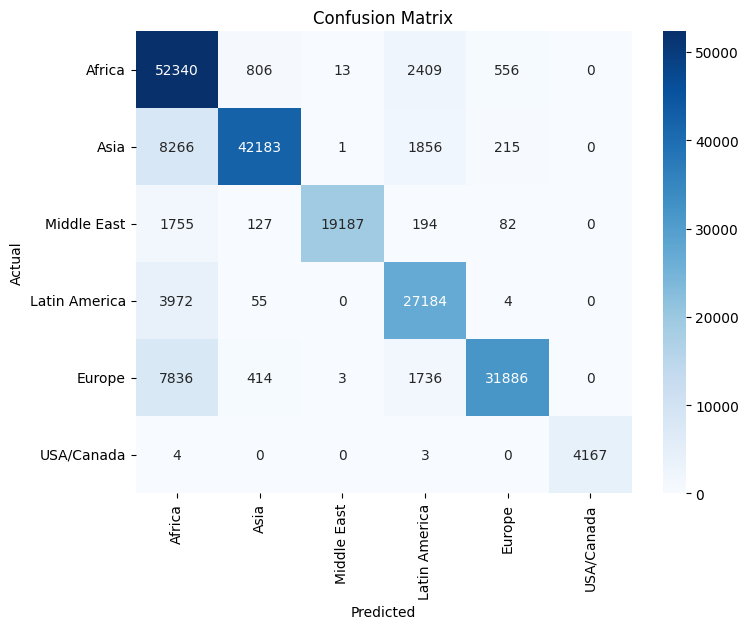

In [ ]:
# plot the confusion matrix

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                    feature  importance
3  region_event_interaction    0.777791
2             event_encoded    0.200937
1            log_fatalities    0.010833
0                fatalities    0.010439


Feature Importance Breakdown:
---


          - region_event_interaction (Importance: 0.777791)

This feature, which represents the interaction between the region and the event type, has the highest importance.
It contributes about 77.78% to the model’s predictions, suggesting that the relationship between regions and event types is a key factor in classifying the regions accurately.


          - event_encoded (Importance: 0.200937)

The event type encoding has a moderate importance of 20.09%.
The type of event also plays a significant role in the model's decision-making, but it's not as crucial as the interaction feature.


          - log_fatalities (Importance: 0.010833)

The log-transformed fatalities feature has a smaller importance of 1.08%.
While fatalities may have some impact on classification, its contribution is much less compared to the interaction and event features.

          - fatalities (Importance: 0.010439)

The original fatalities feature has the lowest importance of 1.04%.
Since the log-transformed fatalities (log_fatalities) has a higher importance, the model seems to rely more on the log-transformed version rather than the raw fatalities count.

    Conclusion:
region_event_interaction is the most influential feature, meaning the combination of the region and event type plays a crucial role in determining the model’s predictions.
The event type is the second most important feature, while the fatalities features (both original and log-transformed) have relatively low importance.

In [ ]:
combined_df.region_encoded.value_counts()

,count
region_encoded,
0,279653
1,263985
4,210199
3,155933
2,105582
5,20917


In [ ]:
combined_df.Region.value_counts()

,count
Region,
Africa,279653
Asia,263985
Middle East,210199
Latin America,155933
Europe,105582
USA/Canada,20917


# **LLM Integration**

In this section, we detail the integration of a Large Language Model (LLM) into our conflict prediction workflow. By leveraging Google's GenerativeAI model through its API, we aim to enhance our system by generating strategic mitigation plans based on the predictions produced by our Random Forest model. This fusion of advanced machine learning techniques and natural language processing allows for more informed and actionable insights.

The LLM generates a holistic and actionable mitigation strategy tailored to the specific conflict type and region.

In [ ]:
from google.generativeai import GenerativeModel
""" Imports the GenerativeModel class, which is the primary interface for interacting with
various generative AI models within the Google Cloud ecosystem."""
import google.generativeai as genai
import os
import re


In [ ]:
# API_KEY = "type your API key here"


In [ ]:
#genai.configure(api_key=API_KEY)

Define a template for generating prompts for a generative AI model to create mitigation strategies for various event types

This function effectively combines the prompt generation and model interaction to create a comprehensive workflow for generating mitigation strategies using a generative AI model

In [ ]:
def prompt(event_type, region="Unknown Region"): # Added a default value for region
    return f"""
    Generate a detailed and actionable mitigation strategy for addressing {event_type} in the {region}. The strategy should include the following components:

    1. Immediate Response Actions:
       - Specific emergency measures to be taken to ensure immediate safety and stabilization.
       - Roles and responsibilities of key responders (e.g., security forces, medical personnel, humanitarian organizations).

    2. Medium-Term Interventions:
       - Programs and initiatives to address underlying issues and reduce the recurrence of conflict.
       - Steps to rebuild trust and promote reconciliation among affected communities.

    3. Long-Term Prevention Measures:
       - Structural changes and policies to prevent future conflicts.
       - Education and awareness campaigns to foster a culture of peace and non-violence.

    4. Key Stakeholders to Involve:
       - Identification of essential stakeholders (e.g., government agencies, NGOs, community leaders, international organizations).
       - Their roles and contributions to the mitigation efforts.

    5. Potential Challenges in Implementation:
       - Anticipated obstacles and resistance.
       - Strategies to overcome these challenges and ensure the effectiveness of the mitigation plan.

    Note: Ensure the strategies are well-structured, clearly numbered, and provide practical, actionable steps. Avoid using bold or special characters.
    """
    return  prompt

In [ ]:
prompt_response = prompt("Violence", region="Africa") # Pass the region when calling prompt

In [ ]:
def generate_mitigation_strategy(event_type):
    model = GenerativeModel("gemini-1.5-flash")
    prompt_text = prompt(event_type)
    response = model.generate_content(
        prompt_text,
        generation_config={
            "max_output_tokens": 8052,
            "temperature": 0.3,
            "top_p": 1
        },
        stream=False
    )
    new_response = "".join(response.candidates[0].content.parts[0].text)
    new_response = re.sub(r"[\*#]", "", new_response)
    return new_response

In [ ]:
prompt_response = prompt("Violence")

In [ ]:
response = generate_mitigation_strategy(prompt_response)

In [ ]:
new_response = "".join(response)
new_response = re.sub(r"[\#]", "", new_response)

In [ ]:
print(new_response)

Functionality of the code above:


---



Generative Model Instance:


model = GenerativeModel("gemini-1.5-flash")
Creates a GenerativeModel instance, likely using Google Generative AI models.
The specific model name "gemini-1.5-flash" a text generation model suitable for the task.


---


Prompt Generation:

prompt_text = prompt(event_type)

Calls the previously defined prompt function to generate a detailed prompt based on the provided event_type.

---
Content Generation:


response = model.generate_content(...)

Uses the GenerativeModel instance (model) to generate content (text) based on the prompt (prompt_text).

---
Several arguments are passed to generate_content:

- prompt_text:

The text prompt defining the desired content.
generation_config: A dictionary containing configuration options for the generation process:

- max_output_tokens:

Limits the total number of tokens generated (set to 8052 in this case).

- temperature:

Controls the randomness of the generated text (0.3 indicates a balance between creativity and coherence).

- top_p:

Influences the sampling strategy for selecting the next word (set to 1, likely for maximum likelihood sampling).

- stream=False:

Indicates that the response should be returned as a whole rather than streamed in parts.

- Response Processing:

new_response = "".join(response.candidates[0].content.parts[0].text)

Extracts the generated text from the response object.
Assumes the first candidate (potentially the most likely generation) and extracts the text content from the first part.

new_response = re.sub(r"[\*#]", "", new_response)
Removes any asterisks (*) or hash characters (#) from the generated text, as instructed by the prompt.
Return Mitigation Strategy:

return new_response
Returns the processed text, which represents the AI-generated mitigation strategy for the specified event type.

In [ ]:
!pip install openai

import openai
import os
import re

In [ ]:
#from google.colab import userdata
#userdata.get('OPENAI_API_KEY')

In [ ]:
def prompt(event_type, region="Unknown Region"): # Added a default value for region
    return f"""
    Generate a detailed and actionable mitigation strategy for addressing {event_type} in the {region}. The strategy should include the following components:

    1. Immediate Response Actions:
       - Specific emergency measures to be taken to ensure immediate safety and stabilization.
       - Roles and responsibilities of key responders (e.g., security forces, medical personnel, humanitarian organizations).

    2. Medium-Term Interventions:
       - Programs and initiatives to address underlying issues and reduce the recurrence of conflict.
       - Steps to rebuild trust and promote reconciliation among affected communities.

    3. Long-Term Prevention Measures:
       - Structural changes and policies to prevent future conflicts.
       - Education and awareness campaigns to foster a culture of peace and non-violence.

    4. Key Stakeholders to Involve:
       - Identification of essential stakeholders (e.g., government agencies, NGOs, community leaders, international organizations).
       - Their roles and contributions to the mitigation efforts.

    5. Potential Challenges in Implementation:
       - Anticipated obstacles and resistance.
       - Strategies to overcome these challenges and ensure the effectiveness of the mitigation plan.

    Note: Ensure the strategies are well-structured, clearly numbered, and provide practical, actionable steps. Avoid using bold or special characters.
    """
    return prompt

In [ ]:
def generate_mitigation_strategy(event_type):
    openai.api_key = "OPENAI_API_KEY"

    response = openai.Completion.create(
        engine="text-davinci-003",  # Choose an appropriate engine
        prompt=prompt(event_type),
        max_tokens=8000,  # Adjust as needed
        temperature=0.3,
        top_p=1,
        n=1,  # Number of responses to generate
        stop=None,
    )

    new_response = response.choices[0].text.strip()
    new_response = re.sub(r"[\*#]", "", new_response)
    return new_response



In [ ]:
# Example usage:
prompt_response = prompt("Violence", region="Africa")
response = generate_mitigation_strategy(prompt_response)
print(response)